In [ ]:
import polars as pl
import plotnine as pn 
import pandas as pd
import numpy as np 
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# luckily the data isnt that big now so its fine
df = pl.read_csv('top10games_sentiments.parquet')

In [10]:
df.head()

game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,review,timestamp_created,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,sadness,joy,love,anger,fear,surprise
str,i64,i64,i64,i64,i64,i64,str,str,i64,i64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64
"""Terraria""",76561199105280506,0,3,1432,42,1390,"""only poopy men play this""","""2023-11-01T12:25:45.000""",0,0,0,0.454545,0,1,0.007617,0.049914,0.002272,0.928956,0.009822,0.001419
"""Terraria""",76561198023056574,166,9,27678,2508,27678,"""boulders""","""2023-10-31T23:37:18.000""",0,0,0,0.456432,0,1,0.067185,0.04525,0.005997,0.275528,0.587827,0.018213
"""Terraria""",76561198801133938,52,9,15015,0,15015,"""jungle slimes.""","""2023-10-31T21:48:54.000""",0,2,0,0.545455,0,1,0.022608,0.0157,0.002225,0.329094,0.62629,0.004084
"""Terraria""",76561199174242068,42,2,1937,6,1937,"""I hate terraria because it too…","""2023-10-31T16:33:31.000""",0,0,0,0.0,0,1,0.073236,0.009079,0.001078,0.914031,0.001945,0.00063
"""Terraria""",76561199498962728,1,1,756,756,462,"""If your normie you don't have …","""2023-10-31T12:12:19.000""",0,0,0,0.47619,0,0,0.048683,0.034301,0.001517,0.835626,0.078487,0.001386


In [ ]:
# getting games' average sentiments 
df.group_by('game').agg([pl.col('sadness').mean().alias('mean_sadness'),
                         pl.col('joy').mean().alias('mean_joy'),
                         pl.col('love').mean().alias('mean_love'),
                         pl.col('anger').mean().alias('mean_anger'),
                         pl.col('fear').mean().alias('mean_fear'),
                         pl.col('surprise').mean().alias('mean_surprise')
                         ])

game,mean_sadness,mean_joy,mean_love,mean_anger,mean_fear,mean_surprise
str,f64,f64,f64,f64,f64,f64
"""PUBG: BATTLEGROUNDS""",0.216807,0.276601,0.007572,0.435619,0.057158,0.006242
"""ELDEN RING""",0.278832,0.341393,0.008389,0.294603,0.064848,0.011934
"""Grand Theft Auto V""",0.197412,0.270414,0.009612,0.468592,0.048077,0.005892
"""Among Us""",0.197519,0.243875,0.010132,0.473726,0.065105,0.009643
"""Counter-Strike 2""",0.176735,0.23337,0.008731,0.525074,0.050649,0.005443
"""Terraria""",0.212866,0.275887,0.011338,0.427607,0.064379,0.007923
"""Garry's Mod""",0.190536,0.273796,0.009854,0.454428,0.063597,0.007789
"""Tom Clancy's Rainbow Six Siege""",0.20411,0.245682,0.010307,0.483593,0.050547,0.005762
"""Team Fortress 2""",0.20212,0.290695,0.013476,0.433061,0.053279,0.007369


In [ ]:
# Found it surprising that elden ring had so many happy reviews, and seeing them makes me think they're just being sarcastic 
df.filter(pl.col('game') == 'ELDEN RING').sort('joy', descending=True).select('review').head(3).to_numpy()

array([['TL;DR Statistically speaking, you\'ll probably like this game, but IMO, its flaws (mostly concerning its core game design) are too glaring to ignore, and I find it overrated. This game doesn\'t really understand the difference between good difficulty and not holding your hand vs being absurdly difficult just because it\'s on brand to do so, which is a shame because the combat is pretty fun and the "secrets" you can discover *would* make you feel accomplished, had you any indication they existed in the first place (inb4 it wouldn\'t be a "secret" then). The open world is alright I guess if you\'re a fan of barren, ugly land masses, but if you\'re expecting any kind of deep story or lOrE from this game, you\'ll either need to plunge your head up your own rear end to find it, or seek answers outside the game from people who already have with deep lore explanation videos.  A friend of mine bought this game for me - he loved it and he thought I would too, even though I was never re

In [ ]:
# ordering for viz
df_pd = df.to_pandas() 
df_pd['game'] = pd.Categorical(df_pd['game'], 
                               categories=['Counter-Strike 2','Terraria',
                                           'Team Fortress 2',
                                            "Tom Clancy's Rainbow Six Siege",
                                            'Grand Theft Auto V',
                                            'Rust',
                                            "Garry's Mod",
                                            'Among Us',
                                            'PUBG: BATTLEGROUNDS',
                                            'ELDEN RING']
                                            [::-1])

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 6605 rows containing non-finite values.


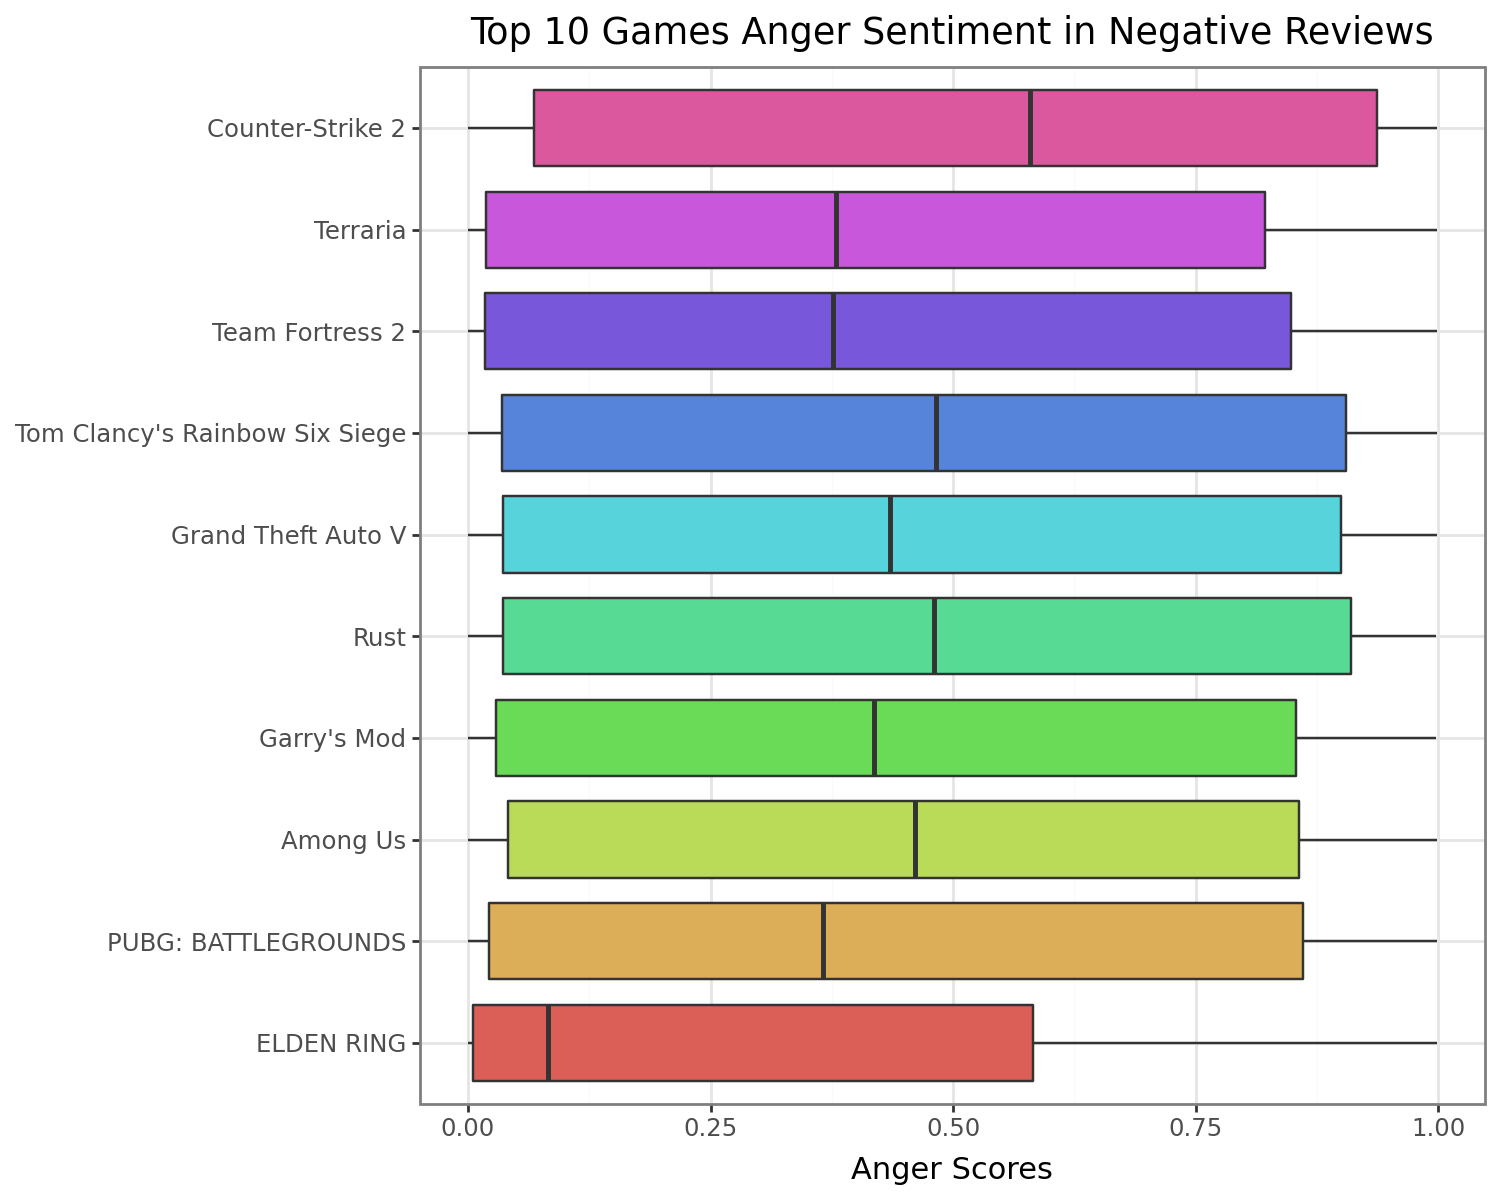

In [ ]:
# boxplots of anger sentiments per game  
(
    pn.ggplot(df_pd, pn.aes('game', 'anger', fill='game'))
    + pn.geom_boxplot(outlier_shape = None) 
    + pn.coord_flip()
    + pn.labs(x='', y='Anger Scores', title='Top 10 Games Anger Sentiment in Negative Reviews') 
    + pn.theme_bw()
    + pn.guides(fill = False)
    + pn.theme(figure_size=(7.5,6))
)

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_boxplot : Removed 6605 rows containing non-finite values.


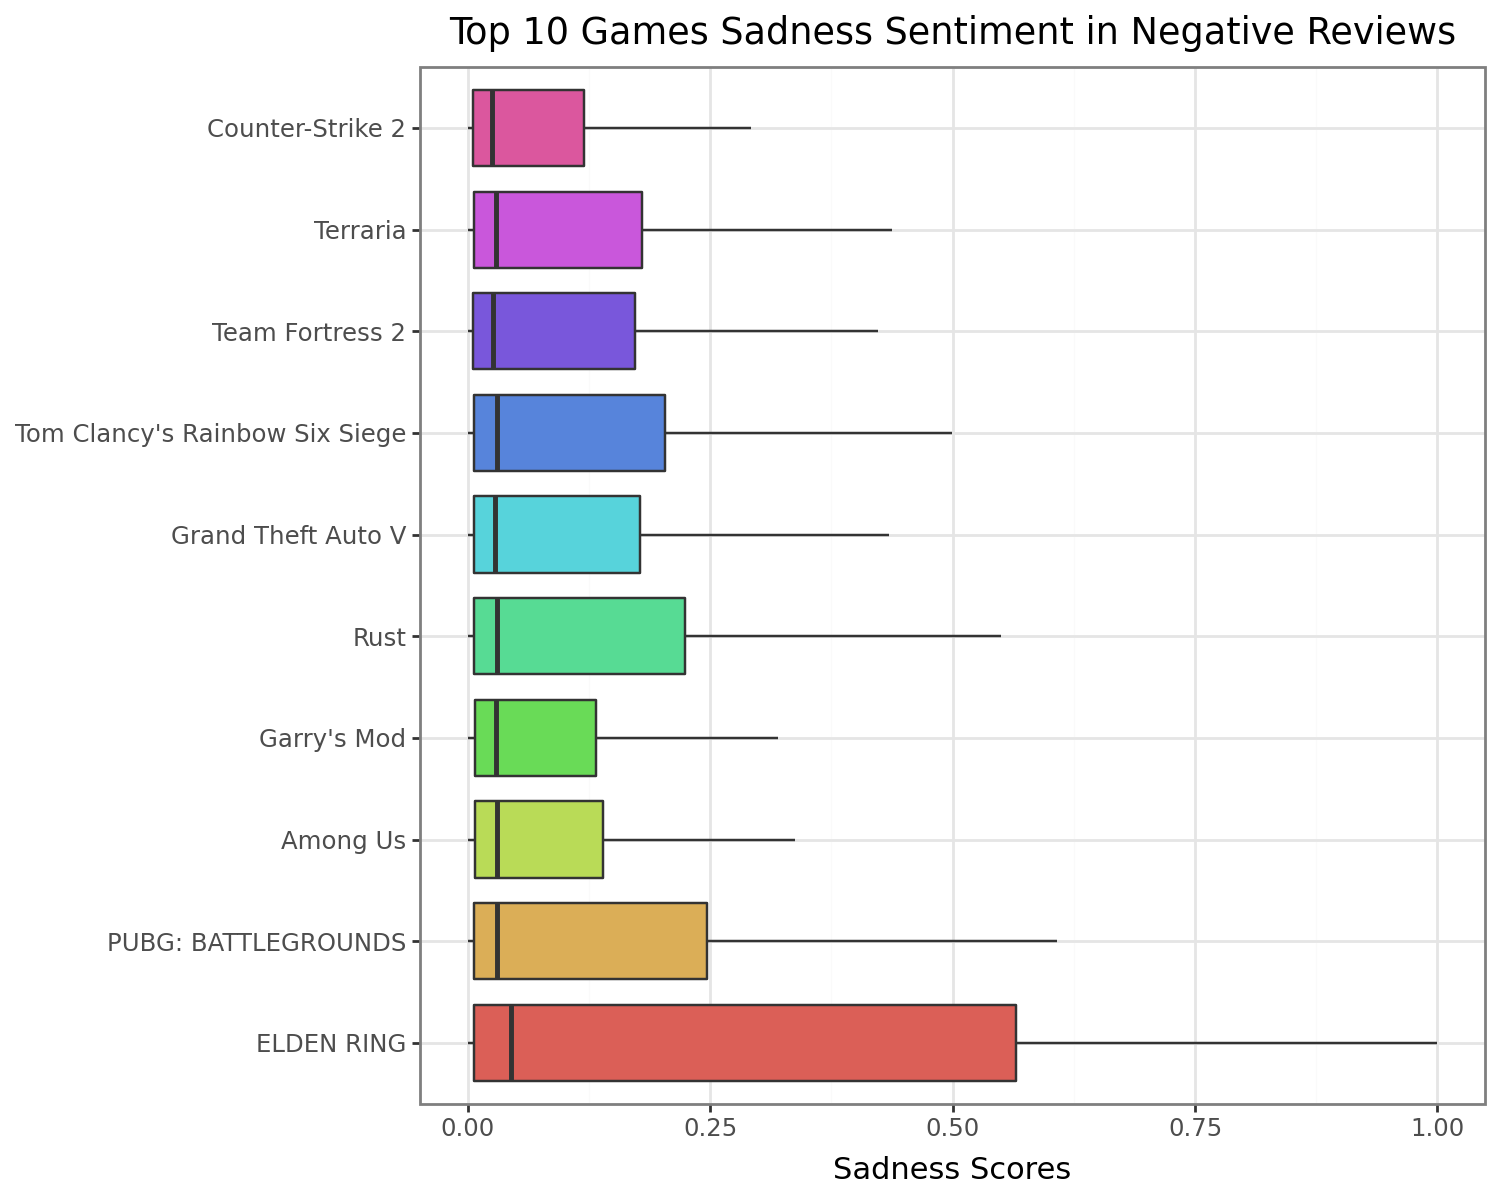

In [ ]:
# boxplots of sadness sentiments per game  
(
    pn.ggplot(df_pd, pn.aes('game', 'sadness', fill='game'))
    + pn.geom_boxplot(outlier_shape = None) 
    + pn.coord_flip()
    + pn.labs(x='', y='Sadness Scores', title='Top 10 Games Sadness Sentiment in Negative Reviews') 
    + pn.theme_bw()
    + pn.guides(fill = False) 
    + pn.theme(figure_size=(7.5,6))
)

In [ ]:
# fitting a negative binomial regression 
# removing love for the sake of multicollinearity
df_glm = df_pd[df_pd['game'] == 'ELDEN RING'][['sadness', 'joy', 'fear', 'surprise', 'anger', 'author_playtime_at_review']].dropna()

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 1131'. Pick better value with 'binwidth'.


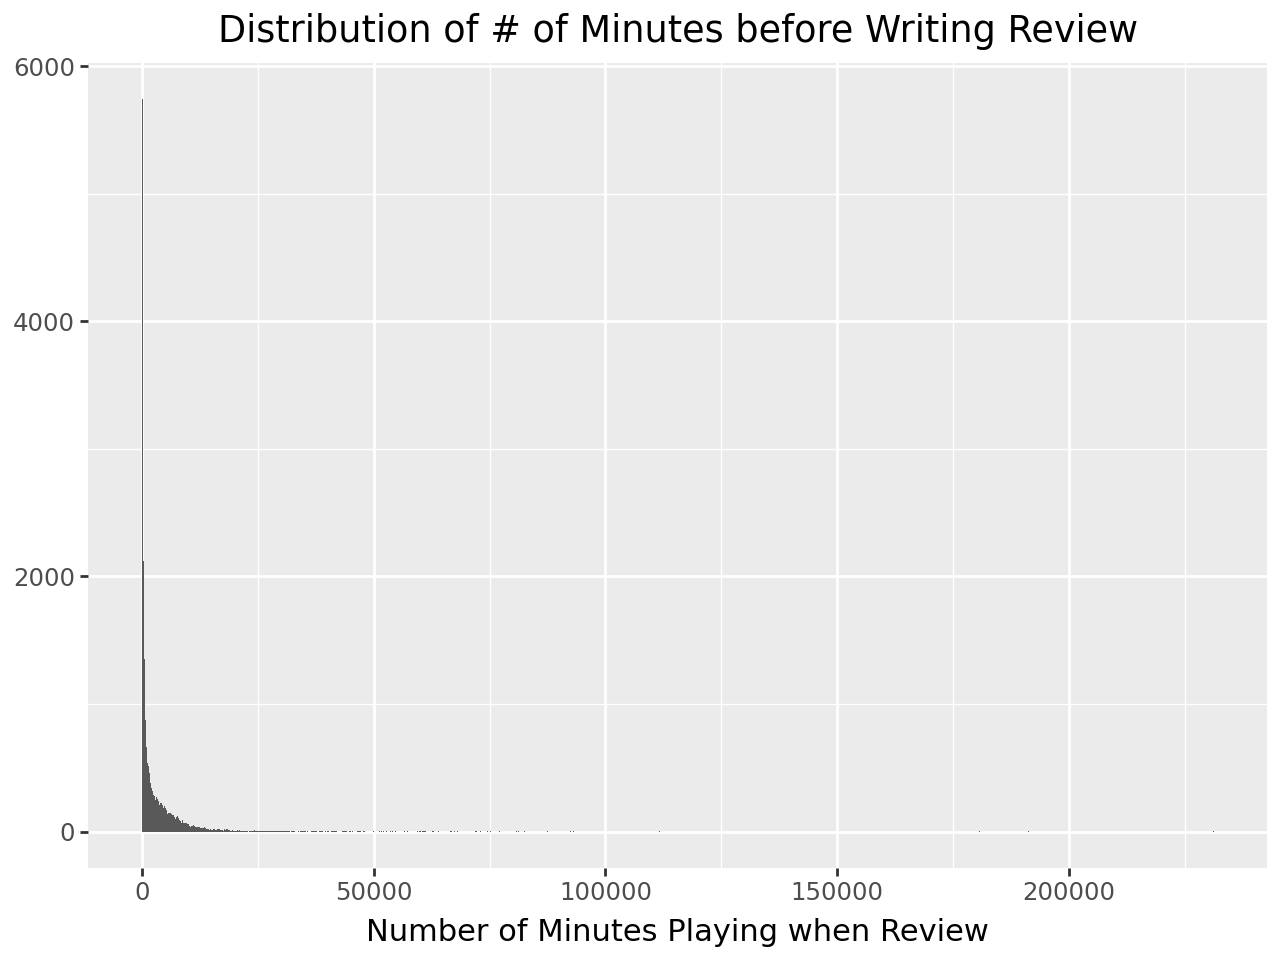

In [ ]:
# seeing if the distribution follows negative binomial distribution 
(
    pn.ggplot(df_glm, pn.aes('author_playtime_at_review'))
    + pn.geom_histogram() 
    + pn.labs(x = 'Number of Minutes Playing when Review', y ='', title = 'Distribution of # of Minutes before Writing Review')

)

In [ ]:
# assessing overdispersion 
np.mean(df_glm['author_playtime_at_review'])

In [ ]:
np.var(df_glm['author_playtime_at_review'])

In [154]:
df_glm.columns

Index(['sadness', 'joy', 'fear', 'surprise', 'anger',
       'author_playtime_at_review'],
      dtype='object')

In [ ]:
# setting formula 
formula = "author_playtime_at_review ~ " + " + ".join(df_glm.columns[0:5].tolist())
formula 

'author_playtime_at_review ~ sadness + joy + fear + surprise + anger'

In [ ]:
# fitting model 
np.random.seed(369)
model = smf.glm(formula=formula, data=df_glm, family=sm.families.NegativeBinomial()).fit()

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.


In [ ]:
# model summary 
print(model.summary())

                     Generalized Linear Model Regression Results                     
Dep. Variable:     author_playtime_at_review   No. Observations:                24893
Model:                                   GLM   Df Residuals:                    24887
Model Family:               NegativeBinomial   Df Model:                            5
Link Function:                           Log   Scale:                          1.0000
Method:                                 IRLS   Log-Likelihood:            -2.2125e+05
Date:                       Thu, 06 Mar 2025   Deviance:                       77149.
Time:                               17:47:26   Pearson chi2:                 1.17e+05
No. Iterations:                            8   Pseudo R-squ. (CS):            0.01333
Covariance Type:                   nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------